In [1]:
import sys
sys.path.append('../src/')

import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
def validity(_x): #Validity function for the 2D case
    a = _x["X"] #Separate the two dimensions for clarity
    b = _x["Y"]
    fc = np.less(np.sqrt( np.power((a-0.3), 2) + np.power((b-0.3), 2)), 0.1) #Circle
    sc = np.less(np.power(np.power(np.power((a-b), 6)-1, 2) + np.power(np.power((a+b), 6)-1, 2), 2), 0.99) #Arcs
    return np.logical_or(fc, sc) #If points are in circle or arcs they are valid

In [3]:
all_datapoints = np.random.rand(20000, 2) #Sample 10000 2D points
all_datapoints = all_datapoints*2.2-1.1 #Scale from -1.1 to 1.1
x_df = pd.DataFrame(all_datapoints, columns = ["X", "Y"])
validity_mask = validity(x_df)
y_df = pd.DataFrame(validity_mask, columns = ["O1"])
all_df = pd.concat([x_df, y_df], axis=1)
display(all_df)

,X,Y,O1
0,0.912786,-0.782398,False
1,0.756529,-0.603289,False
2,0.589558,-0.398533,False
3,0.039959,0.455390,False
4,-0.747615,-0.461445,False
...,...,...,...
19995,-0.201489,-0.478496,False
19996,0.506618,0.112572,False
19997,-0.367424,1.060904,False
19998,0.203279,-0.706635,False


In [4]:
v = 100*np.mean(all_df["O1"])
print(f"{v}% of the points are valid")

8.434999999999999% of the points are valid


In [5]:
def plotcfs(validity, counterfactuals, query, rangearr, dataset=False):
    xx, yy = np.mgrid[rangearr[0,0]:rangearr[0,1]:.001, rangearr[1,0]:rangearr[1,1]:.001]
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_df = pd.DataFrame(grid, columns = ["X", "Y"])
    Z = validity(grid_df)
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
    img = ax.imshow(1-Z.T, cmap="gray", alpha=0.5, origin='lower', extent = rangearr.flatten())
    ax.axis('off')

    ax.scatter(query[0], query[1], s=100, c="k", alpha = 1, marker="x")
    ax.annotate("Query", (query[0]-.15, query[0]+0.1))
    if not dataset: 
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=100, c="k", alpha = 1, marker=".")
        for i in range(np.shape(counterfactuals)[0]):
            ax.plot([query[0], counterfactuals[i,0]], [query[1], counterfactuals[i,1]],c = "k", linestyle="--", lw=1, alpha=0.5)
    else:
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=1, c="k", alpha = 1, marker=".")


In [6]:
x_df

,X,Y
0,0.912786,-0.782398
1,0.756529,-0.603289
2,0.589558,-0.398533
3,0.039959,0.455390
4,-0.747615,-0.461445
...,...,...
19995,-0.201489,-0.478496
19996,0.506618,0.112572
19997,-0.367424,1.060904
19998,0.203279,-0.706635


In [7]:
# import calculate_dtai
from pymoo.core.variable import Real, Integer, Binary, Choice
# importlib.reload(MOCG)
# importlib.reload(calculate_dtai)

data = data_package.DataPackage(features_dataset=x_df,
                           predictions_dataset=y_df,
                           query_x=np.array([[0,0]]),
                           design_targets=design_targets.DesignTargets([design_targets.ContinuousTarget(label="O1",
                                                                          lower_bound=0.9,
                                                                          upper_bound=1.1)]),
                           datatypes=[Real(bounds=(-1.1, 1.1)), Real(bounds=(-1.1, 1.1))])

problem = MOP.MultiObjectiveProblem(data_package=data,
                                prediction_function=validity,
                                constraint_functions=[])

generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem,
                                     pop_size=100,
                                     initialize_from_dataset=True)
generator.generate(n_generations=100)

20000 dataset entries found matching problem parameters
Initial population initialized from dataset of 20000 samples!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |      6 |  0.000000E+00 |  0.8240887956 |             - |             -
     2 |      100 |      9 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      200 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0093313034 |         ideal
     4 |      300 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0009225639 |             f
     5 |      400 |     10 |  0.000000E+00 |  0.000000E+00 |  0.4905817848 |         nadir
     6 |      500 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      600 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0002636913 |             f
     8 |      700 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0002636913 |             f
     9 |      800 |     

In [8]:
generator._dataset_pop[:3]

Population([<pymoo.core.individual.Individual object at 0x000002395C356790>,
           dtype=object)

Let's first run a fairly balanced sampling:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[2283, 4744, 2329, 1879, 2728, 3885, 1790, 1851, 1730, 4088]
Done! Returning CFs


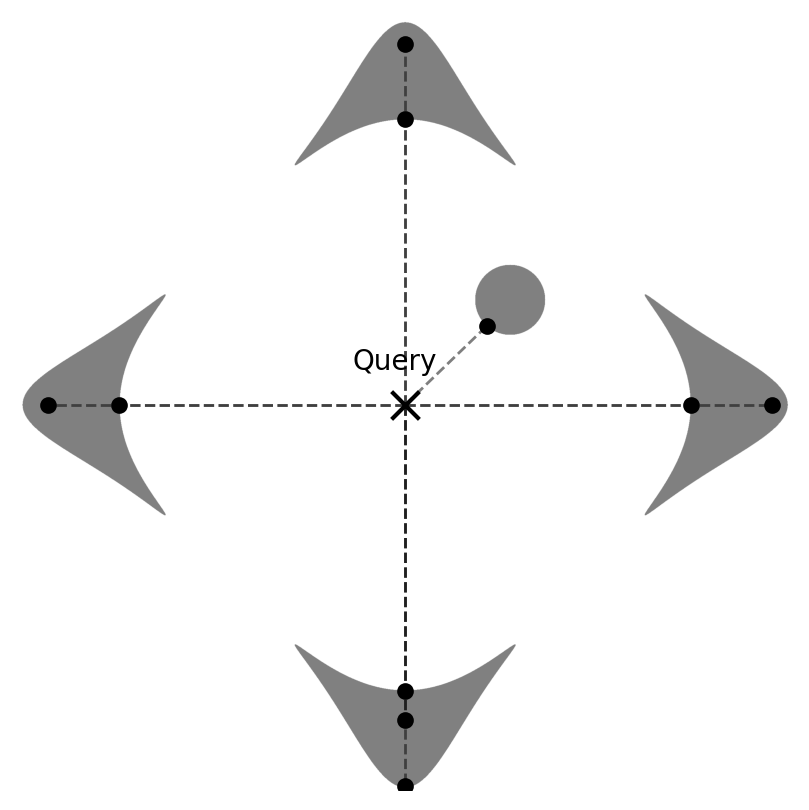

In [9]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Let's take a look at all the valid designs found over the course of optimization:

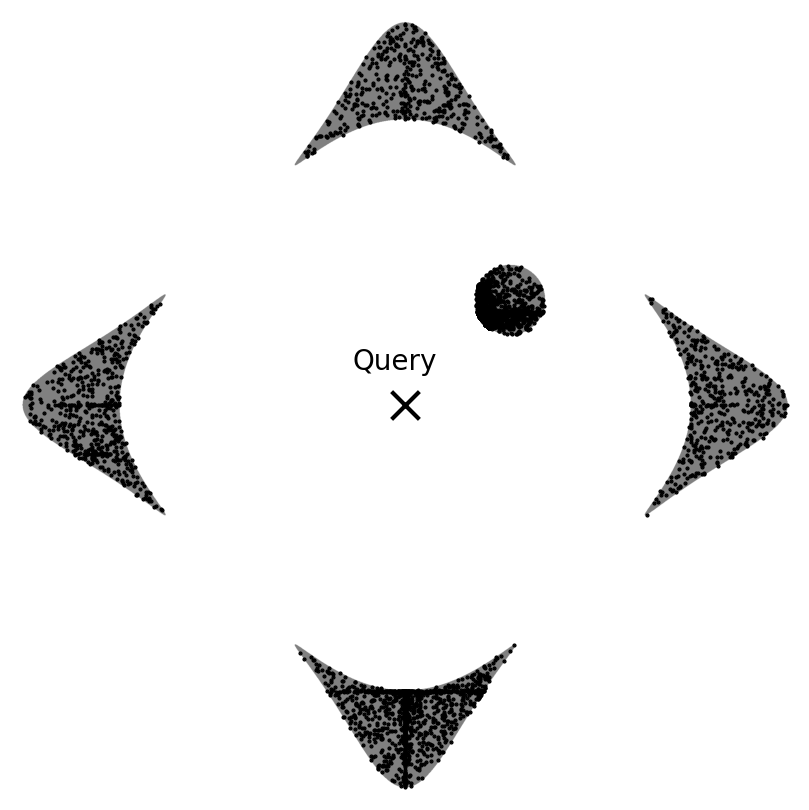

In [10]:
plotcfs(validity, generator._all_cf_x, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]), dataset=True)

Next, we'll weight proximity high:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[2676, 1948, 4744, 2355, 4335, 3695, 4714, 320, 2807, 2412]
Done! Returning CFs


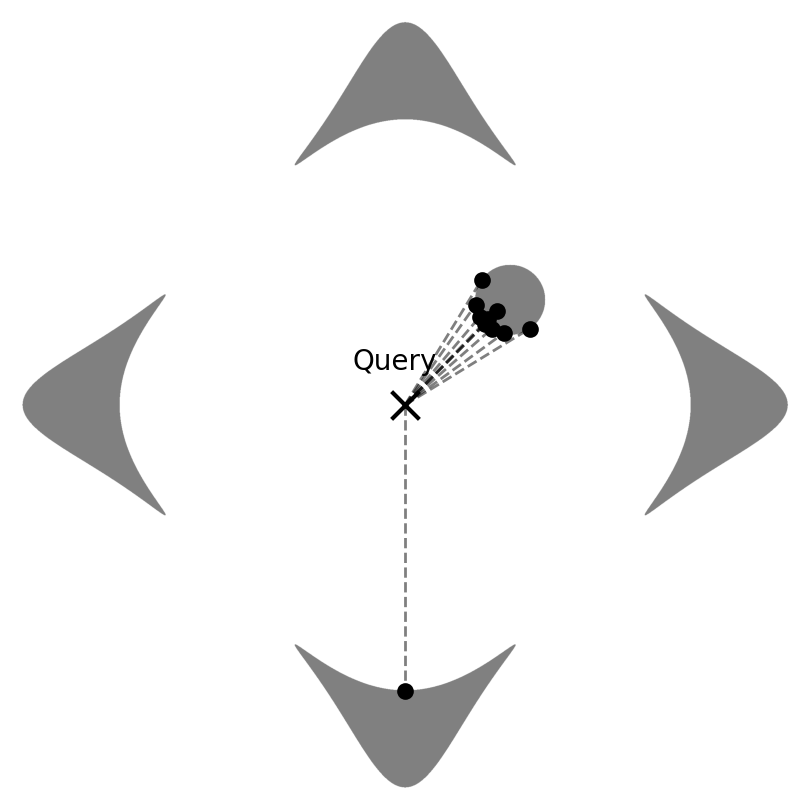

In [11]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=100,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Next, sparsity:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[1742, 3885, 1688, 1851, 2283, 4744, 1879, 2329, 2417, 4498]
Done! Returning CFs


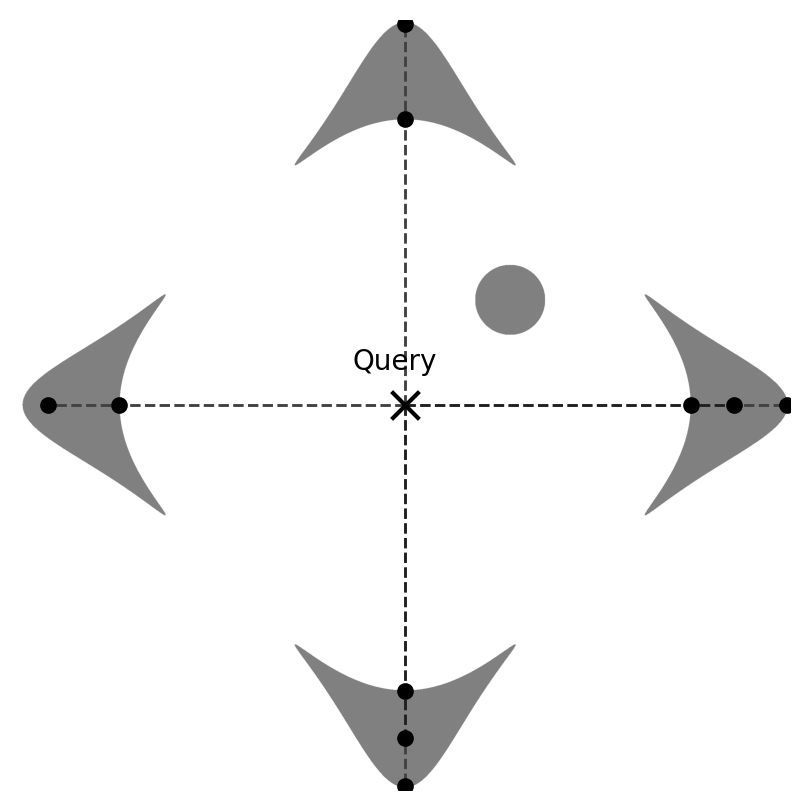

In [12]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=50,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Next, Diversity

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[1688, 1742, 3885, 191, 4532, 202, 1184, 1322, 1505, 1039]
Done! Returning CFs


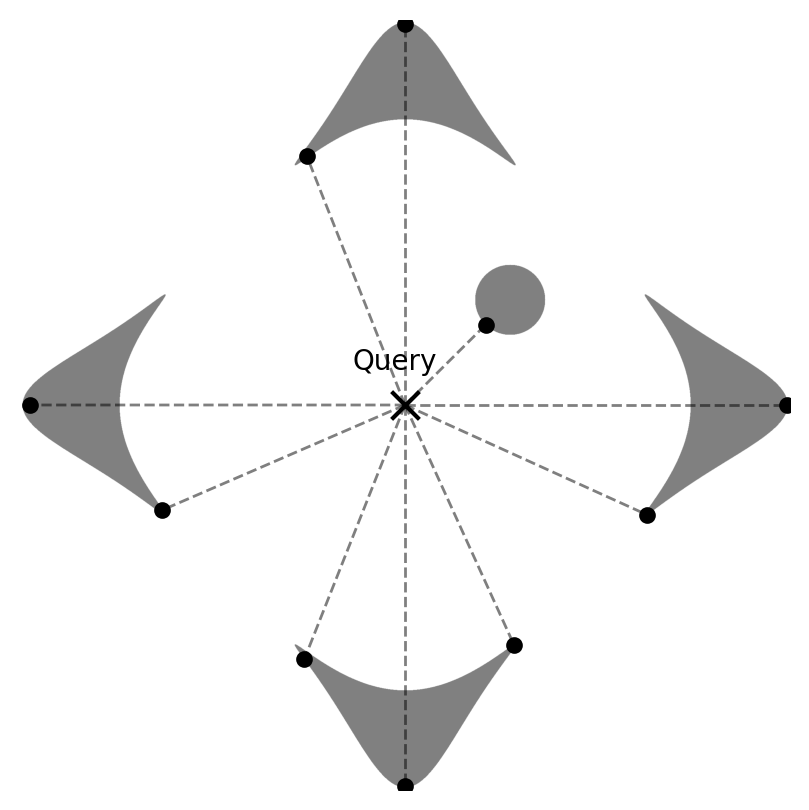

In [13]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=20, include_dataset=False, 
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))